In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Some general plots for the paper:

* plots of all Carla maps

In [11]:
from graph_creator.ActorTimeGraph import ActorTimeGraph

import pandas as pd
pd.set_option('display.max_colwidth', None)

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.spatial import distance
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon, LineString
import pandas as pd
#from src.generate_traffic_data import clean_carla, spawn_scene, run_scene
import carla
import os
os.getcwd()
from datetime import datetime
import time
import random
from tqdm import tqdm
import networkx as nx
import numpy as np
import pickle

os.chdir('../..')
os.getcwd()


from graph_creator.MapGraph import MapGraph
from graph_creator.ActorGraph import ActorGraph
from graph_creator.utilities import make_node_edge_df , check_offroad_actors

from graph_creator.plot_graphs import plot_lane_map_advanced, add_actors_to_map, add_actor_edges_to_map

In [12]:
files = os.listdir("/home/tmuehlen/repos/graph_coverage/carla/data")

In [13]:
# [file.split("scene_")[1].split("_tracks")[0] for file in files if "tracks.parquet" in file]


In [14]:
# scn_ids = [file.split("_")[1] for file in files if "tracks.parquet" in file]
scn_ids = [file.split("scene_")[1].split("_tracks")[0] for file in files if "tracks.parquet" in file]

scn_ids = sorted(scn_ids)
# the following filter includes a lot of scenarios which have offroad actors.
#scn_ids = [scn_id for scn_id in scn_ids if scn_id > "2025-09-05"]
# print(len(scn_ids))
# scn_id = scn_ids[200]
# the following filter is only using updated scenario gen, which hopefully has nearly no offroad actors.
#scn_ids = [scn_id for scn_id in scn_ids if scn_id > "2025-10-02 22:49"]
print(len(scn_ids))


49


In [15]:
#scn_ids = [scn_id for scn_id in scn_ids if ("Town01" in scn_id)]


In [16]:
scn_ids

['2025-10-05 20:53:06.306761_Town01',
 '2025-10-05 20:53:41.635057_Town01',
 '2025-10-05 20:54:34.330511_Town01',
 '2025-10-05 20:55:06.056957_Town01',
 '2025-10-05 20:55:55.532439_Town01',
 '2025-10-05 20:56:40.894877_Town01_Opt',
 '2025-10-05 20:57:17.716974_Town01_Opt',
 '2025-10-05 20:57:58.492657_Town01_Opt',
 '2025-10-05 20:58:31.154340_Town01_Opt',
 '2025-10-05 20:58:55.244183_Town01_Opt',
 '2025-10-05 20:59:21.974340_Town02_Opt',
 '2025-10-05 20:59:54.850969_Town02_Opt',
 '2025-10-05 21:00:26.185596_Town02_Opt',
 '2025-10-05 21:00:43.692470_Town02_Opt',
 '2025-10-05 21:01:19.851805_Town02_Opt',
 '2025-10-05 21:01:40.318093_Town02',
 '2025-10-05 21:02:01.426868_Town02',
 '2025-10-05 21:02:38.110401_Town02',
 '2025-10-05 21:03:03.755088_Town02',
 '2025-10-05 21:03:22.817133_Town02',
 '2025-10-05 21:03:47.111009_Town03',
 '2025-10-05 21:04:08.092528_Town03',
 '2025-10-05 21:04:36.852996_Town03',
 '2025-10-05 21:05:02.037241_Town03',
 '2025-10-05 21:05:37.202227_Town03',
 '2025-10-

In [17]:
scn_ids = ["2025-10-05 20:53:06.306761_Town01", 
"2025-10-05 21:01:40.318093_Town02", 
"2025-10-05 21:04:08.092528_Town03", 
"2025-10-05 21:08:26.598141_Town04", 
"2025-10-05 21:28:36.127587_Town05",
"2025-10-05 21:31:14.544895_Town07"]

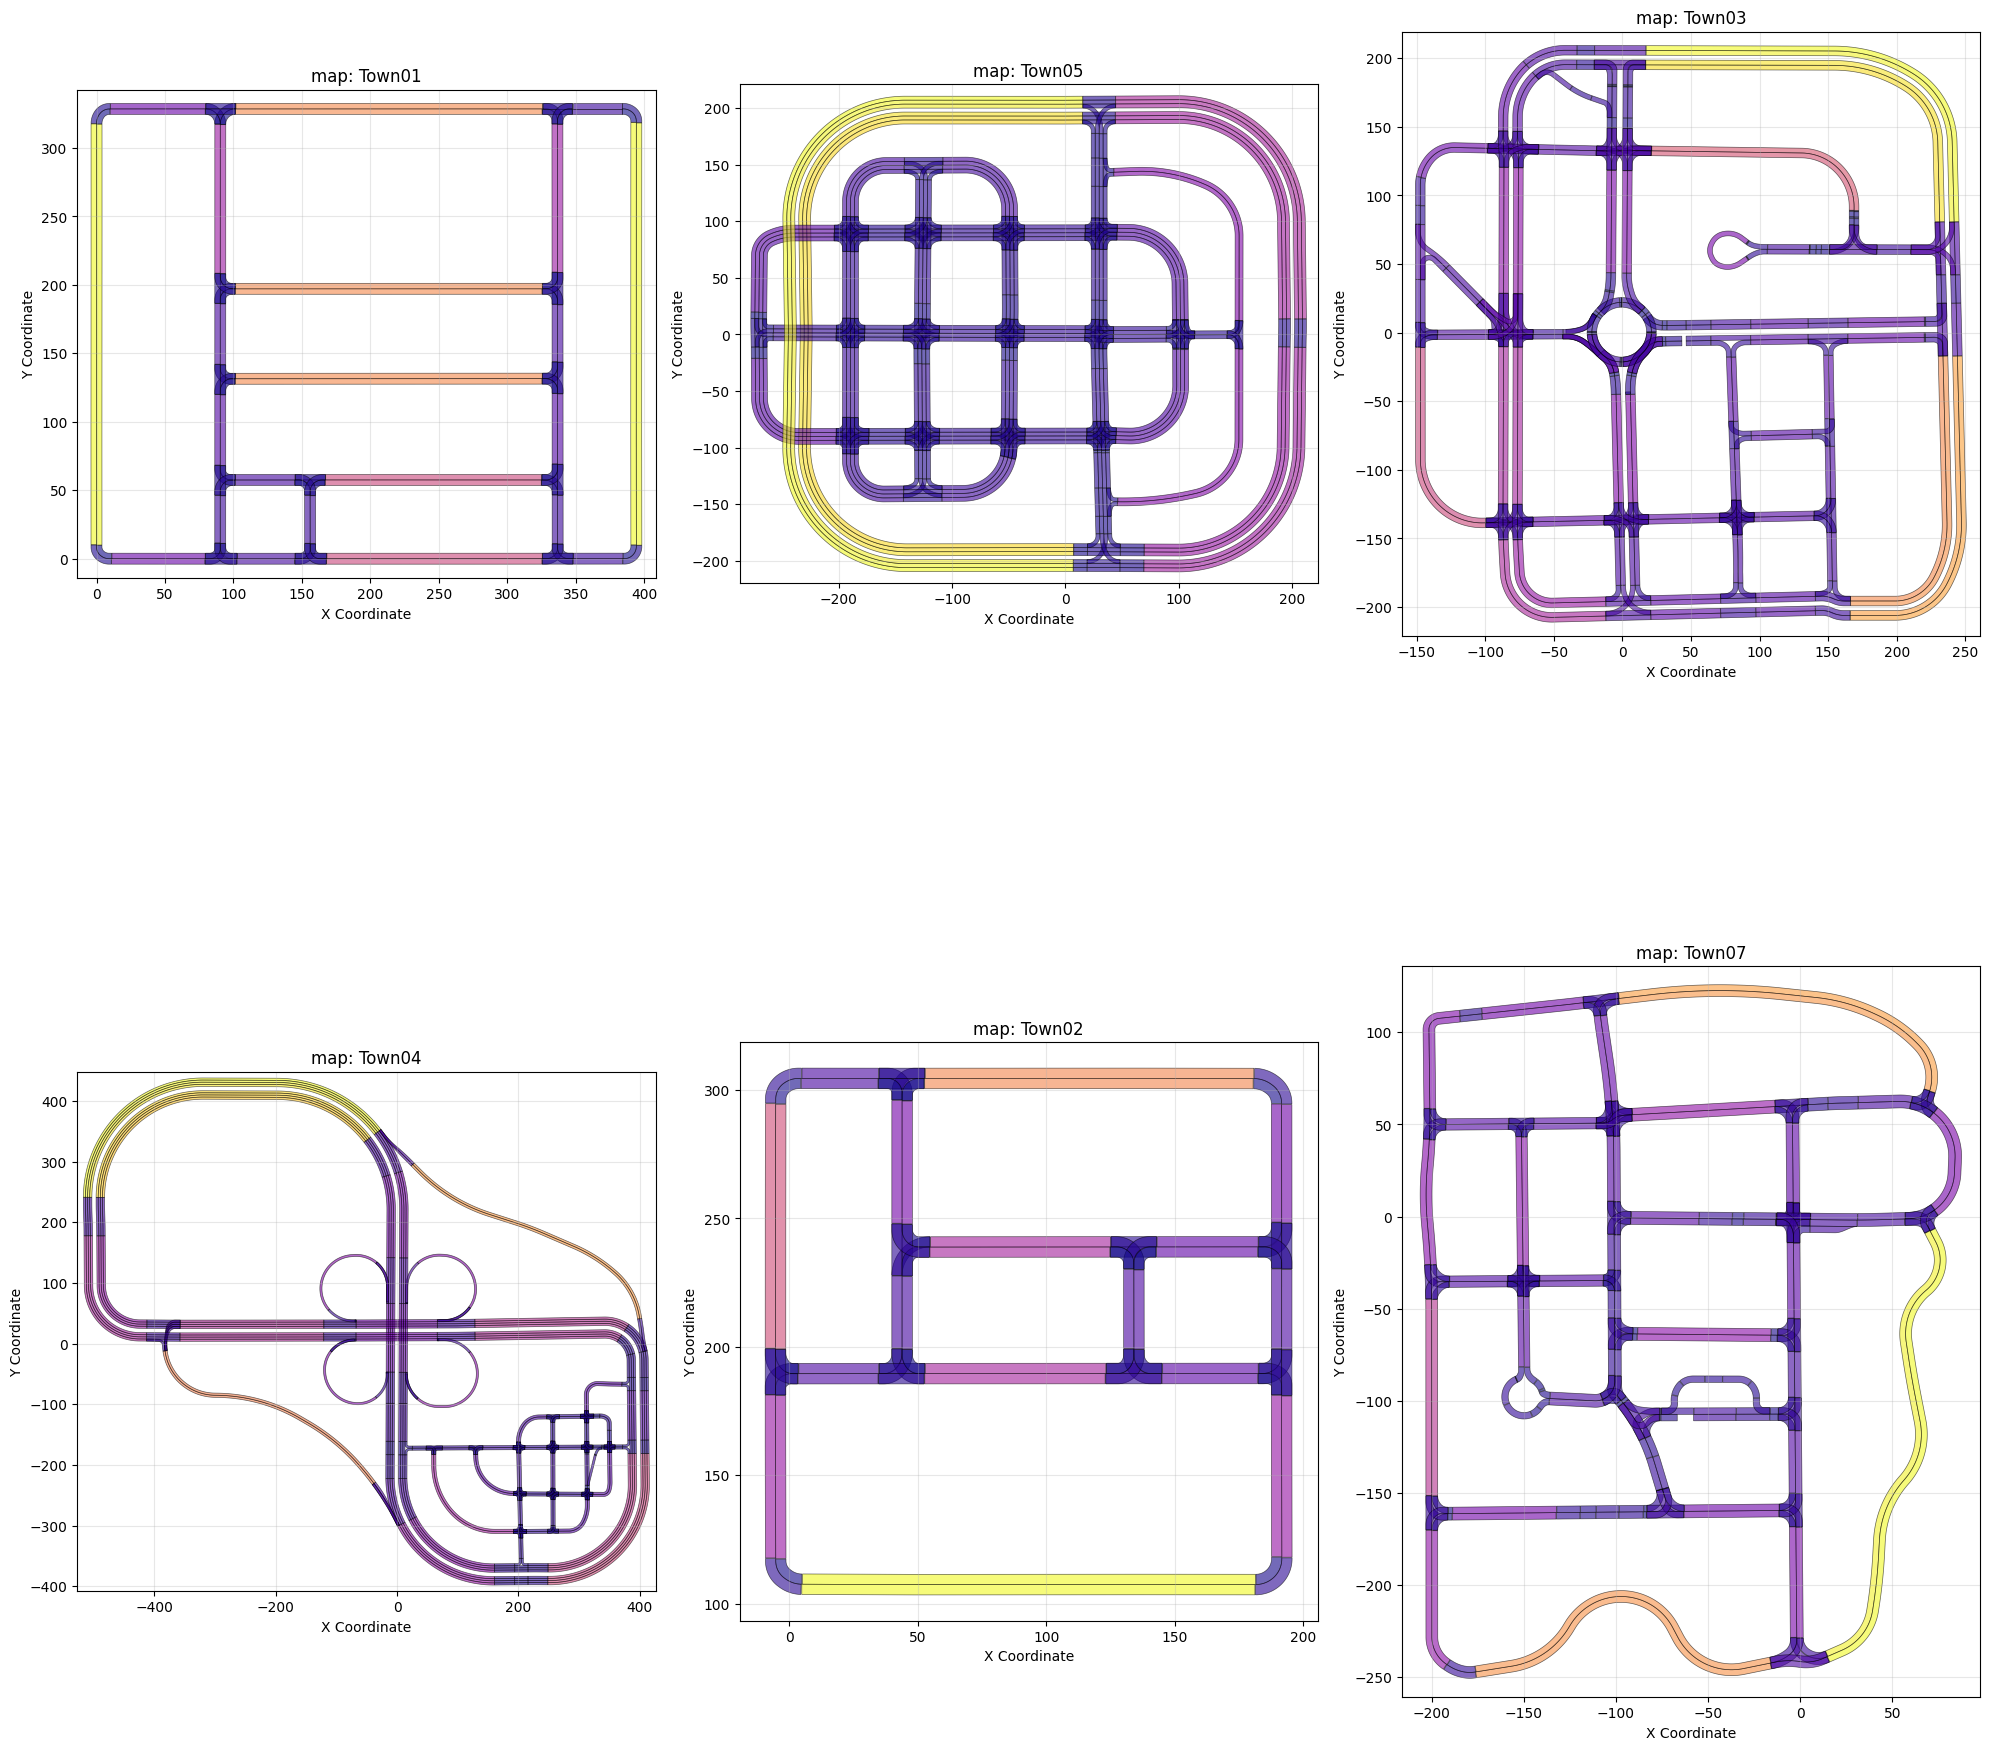

In [19]:
t = 7
fig, axs = plt.subplots(2, 3, figsize=(20, 30))


for i, scn_id in enumerate(scn_ids):
    tracks = pd.read_parquet(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_id}_tracks.parquet')
    tracks['road_lane_id'] = tracks.road_id.astype(str) + '_' + tracks.lane_id.astype(str)
    timestamps = tracks.timestamp.unique().tolist()
    actors = tracks.actor_id.unique().tolist()
    g_map = MapGraph()
    g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_id}_map_graph.pickle')
    ag = ActorGraph()
    ag_carla = ag.from_carla_scenario(tracks, 
        g_map, 
        delta_timestep_s=1.0,
        max_distance_lead_veh_m=40,
        max_distance_opposite_forward_m=60,
        max_distance_opposite_backward_m=10,
        max_distance_neighbor_forward_m=20,
        max_distance_neighbor_backward_m=20,
        max_node_distance_leading=3,
        max_node_distance_neighbor=2,
        max_node_distance_opposite=2,
        )
    ag_carla.actor_graphs.keys()
    # clean up the graphs and components, i.e. remove components with only one node:
    keys = list(ag_carla.actor_graphs.keys())
    for  key in keys:
        ag_carla.actor_components[key] = [ag_carla.actor_components[key][i] for i in range(len(ag_carla.actor_components[key])) if ag_carla.actor_components[key][i].size() > 1]
    ag_timestamps = list(ag_carla.actor_graphs.keys())
    ag_carla.actor_graphs[ag_timestamps[0]].nodes(data=True)
    ag_carla.actor_graphs[ag_timestamps[0]].edges(data=True)
    # remove offroad actors:
    # Still wait for Marius input, if this is legit of not.
    timestamps = sorted(list(ag_carla.actor_graphs.keys()))
    fig, axs[i%2, i%3] = plot_lane_map_advanced(g_map.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = axs[i%2, i%3])
    #fig, ax1 = add_actors_to_map(fig, ax1, ag_carla.actor_graphs[timestamps[t]], actor_size=20, show_actor_labels=False)
    #fig, ax1 = add_actor_edges_to_map(fig, ax1, ag_carla.actor_graphs[timestamps[t]])
    axs[i%2, i%3].set_title(f'map: {scn_id.split("_")[-1]}')

plt.show()